In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK

import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time

In [2]:
!ls

 images				 sample_submission.csv	     torch_utils.py
 images.zip			 sample_submission.csv.zip   train.csv
'Leaf Modeling - NO DNN.ipynb'	 Submission.csv		     train.csv.zip
 __pycache__			 test.csv		     Trained_450.pt
'PyTorch and DNN.ipynb'		 test.csv.zip


In [3]:
torch_utils.seed_everything(947)

In [4]:
train_raw = pd.read_csv("train.csv")
test_raw = pd.read_csv("test.csv")
submission_raw = pd.read_csv("sample_submission.csv")

In [5]:
train_raw.head(7)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250
5,8,Magnolia_Salicifolia,0.070312,0.093750,0.033203,0.001953,0.000000,0.152340,0.007812,0.0,...,0.145510,0.000000,0.041992,0.000000,0.005859,0.0,0.0,0.000000,0.001953,0.013672
6,10,Quercus_Canariensis,0.021484,0.031250,0.017578,0.009766,0.001953,0.042969,0.039062,0.0,...,0.085938,0.000000,0.040039,0.000000,0.009766,0.0,0.0,0.000000,0.039062,0.003906


In [6]:
train_raw.info(null_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 194 columns):
id           990 non-null int64
species      990 non-null object
margin1      990 non-null float64
margin2      990 non-null float64
margin3      990 non-null float64
margin4      990 non-null float64
margin5      990 non-null float64
margin6      990 non-null float64
margin7      990 non-null float64
margin8      990 non-null float64
margin9      990 non-null float64
margin10     990 non-null float64
margin11     990 non-null float64
margin12     990 non-null float64
margin13     990 non-null float64
margin14     990 non-null float64
margin15     990 non-null float64
margin16     990 non-null float64
margin17     990 non-null float64
margin18     990 non-null float64
margin19     990 non-null float64
margin20     990 non-null float64
margin21     990 non-null float64
margin22     990 non-null float64
margin23     990 non-null float64
margin24     990 non-null float64
margin25     

In [7]:
test_raw.head(7)

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812
5,16,0.021484,0.033203,0.021484,0.009766,0.015625,0.035156,0.039062,0.0,0.003906,...,0.000000,0.000000,0.000000,0.000977,0.049805,0.0,0.0,0.027344,0.000000,0.021484
6,19,0.015625,0.025391,0.046875,0.009766,0.005859,0.027344,0.042969,0.0,0.000000,...,0.001953,0.000000,0.000000,0.004883,0.030273,0.0,0.0,0.000977,0.000000,0.024414


In [8]:
test_raw.info(null_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 193 columns):
id           594 non-null int64
margin1      594 non-null float64
margin2      594 non-null float64
margin3      594 non-null float64
margin4      594 non-null float64
margin5      594 non-null float64
margin6      594 non-null float64
margin7      594 non-null float64
margin8      594 non-null float64
margin9      594 non-null float64
margin10     594 non-null float64
margin11     594 non-null float64
margin12     594 non-null float64
margin13     594 non-null float64
margin14     594 non-null float64
margin15     594 non-null float64
margin16     594 non-null float64
margin17     594 non-null float64
margin18     594 non-null float64
margin19     594 non-null float64
margin20     594 non-null float64
margin21     594 non-null float64
margin22     594 non-null float64
margin23     594 non-null float64
margin24     594 non-null float64
margin25     594 non-null float64
margin26    

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

In [10]:
le = LabelEncoder().fit(train_raw.species)
labels = le.transform(train_raw.species)
classes = list(le.classes_)

train = train_raw.drop(["id", "species"], axis=1)
test  = test_raw.drop(["id"], axis=1)
testid = test_raw["id"]

In [11]:
train.head()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,0.044922,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,0.017578,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,0.005859,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [12]:
sss = StratifiedShuffleSplit(10, test_size=0.2, random_state=23)

In [13]:
i = 0
for train_idx, test_idx in sss.split(train, labels):
    X_train = train.values[train_idx]
    y_train = labels[train_idx]
    X_valid = train.values[test_idx]
    y_valid = labels[test_idx]

In [14]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [15]:
classifiers = [
    KNeighborsClassifier(),   
    SVC(kernel="rbf", C=0.025, probability=True, gamma="auto"),
    NuSVC(probability=True,gamma="auto"),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=111),
    AdaBoostClassifier(n_estimators=111),
    GradientBoostingClassifier(n_estimators=111),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()
]

In [16]:
submission_raw.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
1,7,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
2,9,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
3,12,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
4,13,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101


In [17]:
log_cols = ["classifier", "accuracy", "log_loss"]
log = pd.DataFrame(columns=log_cols)

In [18]:
for i, clf in enumerate(classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)
    
    acc = accuracy_score(y_valid, y_pred)
    logloss = log_loss(y_valid, y_pred_proba)
    
    name = clf.__class__.__name__
    
    print("+-"*45)
    print("Classifier: {}".format(name))
    print("Accuracy Score: {}%".format(acc*100.0))
    print("Log loss Score: {}".format(logloss))
    
    log.loc[i, "classifier"] = name
    log.loc[i, "accuracy"] = acc
    log.loc[i, "log_loss"] = logloss
print("+-"*45)

+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Classifier: KNeighborsClassifier
Accuracy Score: 87.37373737373737%
Log loss Score: 1.1972188656459002
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Classifier: SVC
Accuracy Score: 81.81818181818183%
Log loss Score: 4.596370812634155
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Classifier: NuSVC
Accuracy Score: 88.38383838383838%
Log loss Score: 2.4672976767859947
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Classifier: DecisionTreeClassifier
Accuracy Score: 61.61616161616161%
Log loss Score: 13.257308111177935
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Classifier: RandomForestClassifier
Accuracy Score: 96.96969696969697%
Log loss Score: 0.7746469376649936
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

/home/numan947/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/numan947/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


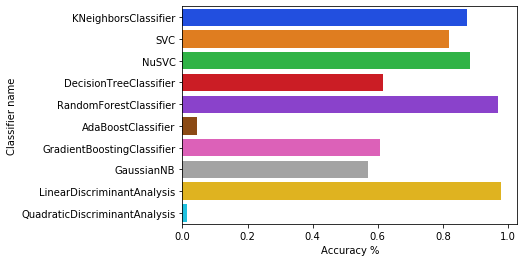

In [19]:
sns.barplot(x="accuracy", y="classifier", data=log, palette="bright")
plt.xlabel("Accuracy %")
plt.ylabel("Classifier name")
plt.show()

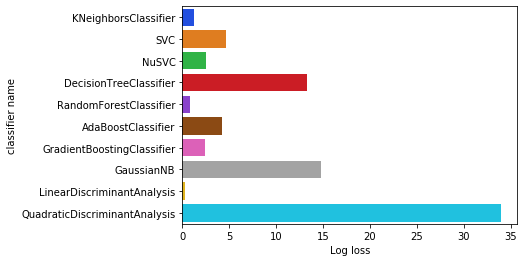

In [20]:
sns.barplot(x="log_loss", y="classifier", data=log, palette="bright")
plt.xlabel("Log loss")
plt.ylabel("classifier name")
plt.show()

In [21]:
perfect_clf = RandomForestClassifier(n_estimators=200)
perfect_clf.fit(train, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
test_pred = perfect_clf.predict_proba(test)
sub = pd.DataFrame(test_pred, columns=classes)
sub.insert(0, "id", testid)
sub.to_csv("Submission.csv", index=False)

In [23]:
sub.shape

(594, 100)

In [101]:
from sklearn.metrics import confusion_matrix

In [102]:
y_pred = perfect_clf.predict(X_valid)

In [103]:
conf = confusion_matrix(y_valid, y_pred)

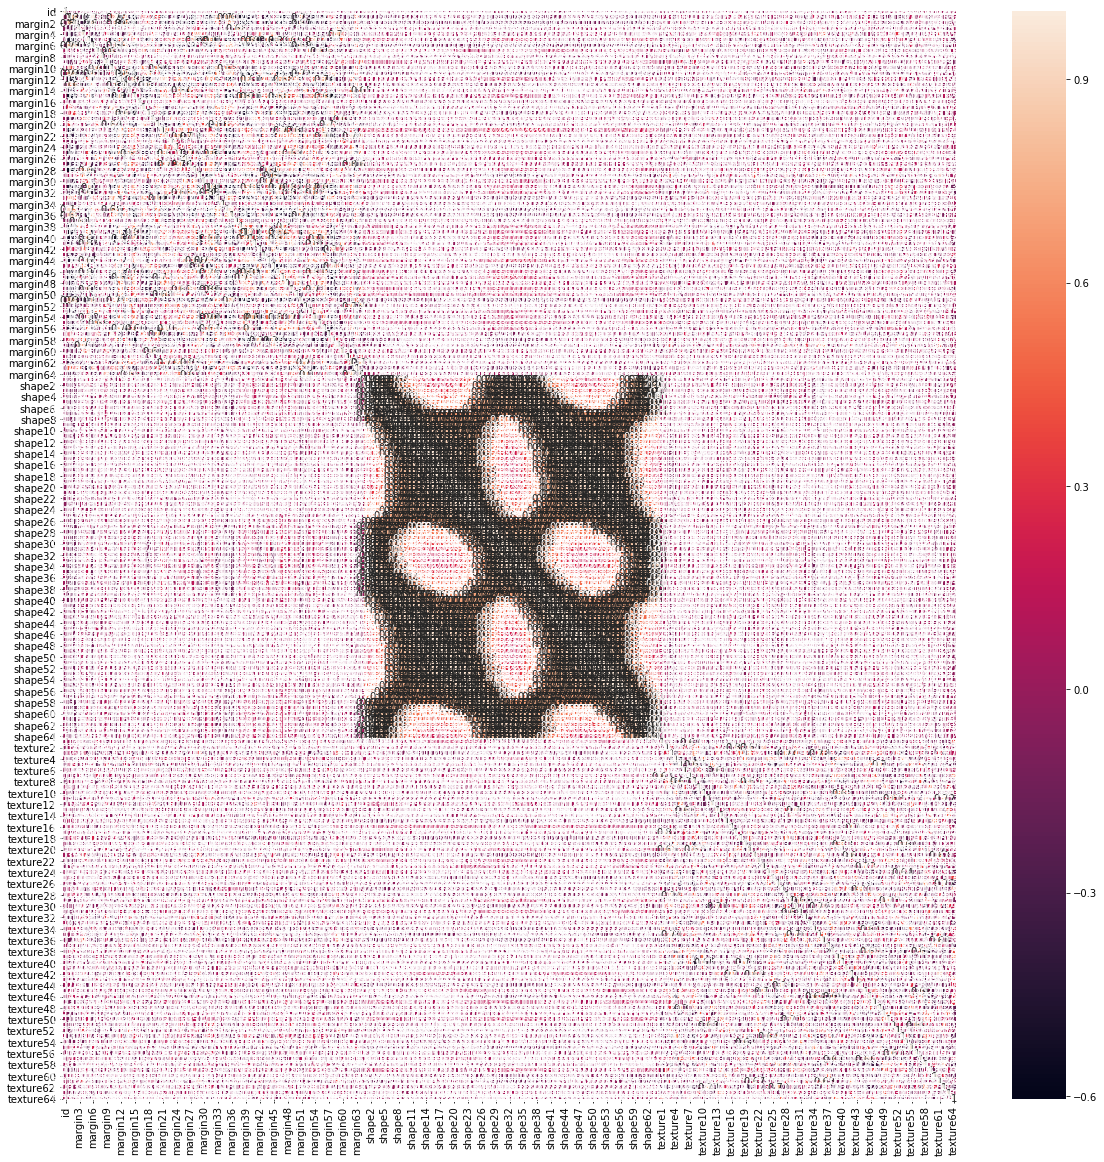

In [109]:
plt.figure(figsize=(20,20))
sns.matrix.heatmap(train_raw.corr(), annot=True)

In [110]:
from sklearn.decomposition import PCA

In [111]:
pca = PCA(n_components="mle")

In [112]:
pca.fit(train)

PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [113]:
x_pca = pca.transform(train)

In [115]:
x_pca.shape, train.shape

((990, 191), (990, 192))

In [125]:
classifiers = [
    KNeighborsClassifier(),   
    SVC(kernel="rbf", C=0.025, probability=True, gamma="auto"),
    NuSVC(probability=True,gamma="auto"),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=111),
    AdaBoostClassifier(n_estimators=111),
    GradientBoostingClassifier(n_estimators=111),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    xgb.XGBClassifier(n_estimators=111, max_depth=4,n_jobs=4)
]

for i, clf in enumerate(classifiers):
    clf.fit(pca.transform(X_train), y_train)
    y_pred = clf.predict(pca.transform(X_valid))
    y_pred_proba = clf.predict_proba(pca.transform(X_valid))
    
    acc = accuracy_score(y_valid, y_pred)
    logloss = log_loss(y_valid, y_pred_proba)
    
    name = clf.__class__.__name__
    
    print("+-"*45)
    print("Classifier: {}".format(name))
    print("Accuracy Score: {}%".format(acc*100.0))
    print("Log loss Score: {}".format(logloss))
    
    log.loc[i, "classifier"] = name
    log.loc[i, "accuracy"] = acc
    log.loc[i, "log_loss"] = logloss
print("+-"*45)

+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Classifier: KNeighborsClassifier
Accuracy Score: 87.37373737373737%
Log loss Score: 1.1972188656459002
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Classifier: SVC
Accuracy Score: 81.81818181818183%
Log loss Score: 4.59637172758899
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Classifier: NuSVC
Accuracy Score: 88.38383838383838%
Log loss Score: 2.474575749298964
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Classifier: DecisionTreeClassifier
Accuracy Score: 49.494949494949495%
Log loss Score: 17.4438264620762
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Classifier: RandomForestClassifier
Accuracy Score: 94.44444444444444%
Log loss Score: 1.5938159997065415
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-

/home/numan947/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Classifier: XGBClassifier
Accuracy Score: 81.81818181818183%
Log loss Score: 1.1344008122693108
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-


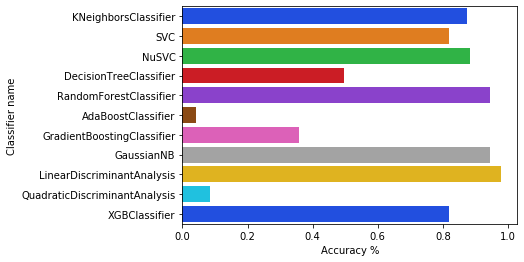

In [126]:
sns.barplot(x="accuracy", y="classifier", data=log, palette="bright")
plt.xlabel("Accuracy %")
plt.ylabel("Classifier name")
plt.show()

In [127]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [131]:
clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, nthread=2)

In [136]:
from sklearn.model_selection import RandomizedSearchCV
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=param_comb, n_jobs=4, cv=skf.split(train, labels), verbose=3, random_state=1001, scoring="accuracy")
random_search.fit(train, labels)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  4.6min finished
/home/numan947/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fd987bbded0>,
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=600,
                                           n_jobs=1, nthread=2,
                                           objectiv...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn',

In [147]:
clf = random_search.best_estimator_

In [149]:
y_pred = clf.predict(train)
y_pred_proba = clf.predict_proba(train)

In [150]:
acc = accuracy_score(labels, y_pred)
logloss = log_loss(labels, y_pred_proba)

In [151]:
print(acc, logloss)

1.0 0.35025514687101045


In [152]:
test_pred = perfect_clf.predict_proba(test)
sub = pd.DataFrame(test_pred, columns=classes)
sub.insert(0, "id", testid)
sub.to_csv("Submission.csv", index=False)